# Imports

In [1]:
import sys
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import copy

from minot.ClusterTools import map_tools
import pitszi

import macsj0717_libs as libs

sigma2fwhm = 2 * np.sqrt(2*np.log(2))

# Parameters

In [2]:
outdir = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/RadialFitInducedFiltering/'

#----- Cluster parameters
cl_redshift = 0.546
cl_M500     = 25*1e14*u.Msun
cl_coord    = SkyCoord(109.3870*u.deg, 37.7525*u.deg, frame='icrs')

#----- Fluctuation model parameters
Linj = 750*u.kpc
Norm = 0.5

#----- Sampling
reso = 4*u.arcsec
FoV = 4*u.arcmin
los_reso = 100*u.kpc
los_size = 2*u.Mpc

#----- Pk binning
Nbins_pk = 30
scale_bins = 'lin'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(18.2*u.arcsec)

#----- Analysis parameters
mask_theta = 1.5*u.arcmin
apply_radial_model = True
remove_GNFW_core = True
smw = 40*u.arcsec

Nsim = 1000
Nmc = 1

In [3]:
#===== Input model
inpars = [
    {'ell_q':1,
     'Pmod':'A10MD',
     'da':0.0, 'db':0.0, 'dc':0.0,
     'dRA':0*u.arcsec, 'dDec':0*u.arcsec,
    },
    {'ell_q':1,
     'Pmod':'A10MD',
     'da':0.0, 'db':0.0, 'dc':0.0,
     'dRA':20*u.arcsec, 'dDec':20*u.arcsec,
    },
    {'ell_q':0.7,
     'Pmod':'A10MD',
     'da':0.0, 'db':0.0, 'dc':0.0,
     'dRA':20*u.arcsec, 'dDec':20*u.arcsec,
    },
    {'ell_q':0.7,
     'Pmod':'A10MD',
     'da':0.1, 'db':-0.7, 'dc':-0.2,
     'dRA':20*u.arcsec, 'dDec':20*u.arcsec,
    }
]

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


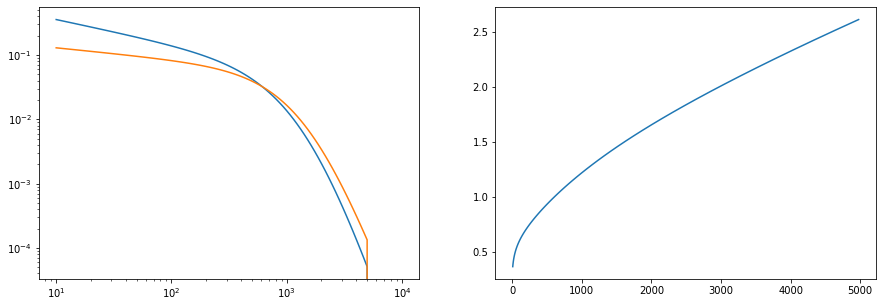

In [4]:
t1 = pitszi.Model(redshift=cl_redshift, M500=cl_M500, silent=True)
t1.set_pressure_profile_universal_param(inpars[3]['Pmod'])
t2 = pitszi.Model(redshift=cl_redshift, M500=cl_M500, silent=True)
t2.set_pressure_profile_universal_param(inpars[3]['Pmod'])
t2.model_pressure_profile['a'] += inpars[3]['da']
t2.model_pressure_profile['b'] += inpars[3]['db']
t2.model_pressure_profile['c'] += inpars[3]['dc']

r, p1 = t1.get_pressure_profile(np.logspace(1,4,100)*u.kpc)
r, p2 = t2.get_pressure_profile(np.logspace(1,4,100)*u.kpc)

fig = plt.figure(0, figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.loglog(r,p1)
plt.loglog(r,p2)
ax = plt.subplot(1, 2, 2)
plt.plot(r,p2.value/p1.value)

In [5]:
#===== Fit model
fitpar_prof1 = {
    'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
    'ZL':{'guess':[0,1e-5],'unit':None},
}

fitpar_prof2 = {
    'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
    'RA': {'guess':[cl_coord.ra.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.ra.to_value('deg')-0.5/60, cl_coord.ra.to_value('deg')+0.5/60]},
    'Dec': {'guess':[cl_coord.dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.dec.to_value('deg')-0.5/60, cl_coord.dec.to_value('deg')+0.5/60]},
    'ZL':{'guess':[0,1e-5],'unit':None},
}

fitpar_prof3 = {
    'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
    'RA': {'guess':[cl_coord.ra.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.ra.to_value('deg')-0.5/60, cl_coord.ra.to_value('deg')+0.5/60]},
    'Dec': {'guess':[cl_coord.dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.dec.to_value('deg')-0.5/60, cl_coord.dec.to_value('deg')+0.5/60]},
    'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
    'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
    'ZL':{'guess':[0,1e-5],'unit':None},
}

fitpar_prof4 = {
    'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
    'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
    'RA': {'guess':[cl_coord.ra.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.ra.to_value('deg')-0.5/60, cl_coord.ra.to_value('deg')+0.5/60]},
    'Dec': {'guess':[cl_coord.dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.dec.to_value('deg')-0.5/60, cl_coord.dec.to_value('deg')+0.5/60]},
    'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
    'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
    'ZL':{'guess':[0,1e-5],'unit':None},
}

fitpar_prof5 = {
    'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
    'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
    'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
    'b': {'guess':[5, 0.5], 'unit': None, 'limit':[2, 8]},
    'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[0, 2]},
    'RA': {'guess':[cl_coord.ra.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.ra.to_value('deg')-0.5/60, cl_coord.ra.to_value('deg')+0.5/60]},
    'Dec': {'guess':[cl_coord.dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.dec.to_value('deg')-0.5/60, cl_coord.dec.to_value('deg')+0.5/60]},
    'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
    'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
    'ZL':{'guess':[0,1e-5],'unit':None},
}

In [6]:
#===== Instrument parameters
beam_FWHM = 18.2*u.arcsec
TF        = libs.get_TF()

In [7]:
#===== Get the data
cl_head, y2jy, cl_img, cl_img1, cl_img2, cl_jk, cl_ps, cl_rms, cl_noise, cl_mask = libs.extract_data(FoV, reso, 1000)

# Analysis

In [8]:
pk0mc = np.zeros((len(inpars), Nmc, Nbins_pk))
pk1mc = np.zeros((len(inpars), Nmc, Nbins_pk))
pk2mc = np.zeros((len(inpars), Nmc, Nbins_pk))
pk3mc = np.zeros((len(inpars), Nmc, Nbins_pk))
pk4mc = np.zeros((len(inpars), Nmc, Nbins_pk))
pk5mc = np.zeros((len(inpars), Nmc, Nbins_pk))
pkref = np.zeros((len(inpars), Nbins_pk))

In [9]:
noise_scale = 1e-2

#===== Loop over the input models
for j in range(len(inpars)):
    pars = inpars[j]
    print('--- Input parameters ', j, '/', len(inpars))
    print(pars)
    
    #----- Generate model
    cl_mock = pitszi.Model(name='Model', RA=cl_coord.ra+pars['dRA'], Dec=cl_coord.dec+pars['dDec'], 
                           redshift=cl_redshift, M500=cl_M500, silent=True, output_dir=outdir)
    cl_mock.set_pressure_profile_universal_param(pars['Pmod'])
    cl_mock.model_pressure_profile['a'] += pars['da']
    cl_mock.model_pressure_profile['b'] += pars['db']
    cl_mock.model_pressure_profile['c'] += pars['dc']
    cl_mock.triaxiality = {'min_to_maj_axis_ratio':pars['ell_q'], 'int_to_maj_axis_ratio':pars['ell_q'],
                           'euler_angle1':0*u.deg, 'euler_angle2':90*u.deg, 'euler_angle3':0*u.deg}
    cl_mock.model_pressure_fluctuation = {'name':'CutoffPowerLaw',
                                          'statistics':'lognormal',
                                          'Ldis':1*u.kpc,
                                          'Linj':Linj,
                                          'Norm':Norm,
                                          'slope':-11.0/3}
    cl_mock.map_header   = cl_head
    cl_mock.los_reso     = los_reso
    cl_mock.los_size     = los_size
    cl_mock.R_truncation = 10*u.Mpc
    
    #----- Generate model
    cl_model = pitszi.Model(name='Model', RA=cl_coord.ra, Dec=cl_coord.dec, 
                            redshift=cl_redshift, M500=cl_M500, 
                            silent=True, output_dir=outdir)
    cl_model.set_pressure_profile_universal_param(pars['Pmod'])
    cl_model.triaxiality = {'min_to_maj_axis_ratio':1, 'int_to_maj_axis_ratio':1,
                            'euler_angle1':0*u.deg, 'euler_angle2':90*u.deg, 'euler_angle3':0*u.deg}
    cl_model.model_pressure_fluctuation = {'name':'CutoffPowerLaw',
                                           'statistics':'lognormal',
                                           'Ldis':1*u.kpc,
                                           'Linj':Linj,
                                           'Norm':Norm,
                                           'slope':-11.0/3}
    cl_model.map_header   = cl_head
    cl_model.los_reso     = los_reso
    cl_model.los_size     = los_size
    cl_model.R_truncation = 10*u.Mpc
    
    #===== Loop over the simulations
    for i in range(Nmc):
        print('----- MC ', i+1, '/', Nmc)
            
        #----- Generate data
        cl_img = cl_mock.get_sz_map(no_fluctuations=True, irfs_convolution_beam=beam_FWHM, irfs_convolution_TF=TF) #+ cl_noise[i]*noise_scale
        cl_data = libs.def_data(cl_img, cl_head, cl_noise, cl_mask, beam_FWHM, TF, outdir, Nsim)
        #cl_data.noise_rms *= noise_scale
        
        #----- Fit the profile data
        cl_Rinfer1 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=True, output_dir=outdir)
        _ = cl_Rinfer1.run_curvefit_profile(fitpar_prof1, show_fit_result=False, set_bestfit=True)
        cl_Rinfer2 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=True, output_dir=outdir)
        _ = cl_Rinfer2.run_curvefit_profile(fitpar_prof2, show_fit_result=False, set_bestfit=True)
        cl_Rinfer3 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=True, output_dir=outdir)
        _ = cl_Rinfer3.run_curvefit_profile(fitpar_prof3, show_fit_result=False, set_bestfit=True)
        cl_Rinfer4 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=True, output_dir=outdir)
        _ = cl_Rinfer4.run_curvefit_profile(fitpar_prof4, show_fit_result=False, set_bestfit=True)
        cl_Rinfer5 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=True, output_dir=outdir)
        _ = cl_Rinfer5.run_curvefit_profile(fitpar_prof5, show_fit_result=False, set_bestfit=True)
        
        #----- Compute the ROI
        roi0 = libs.def_roi(cl_head, cl_mock,          mask_theta=mask_theta, show=False)
        roi1 = libs.def_roi(cl_head, cl_Rinfer1.model, mask_theta=mask_theta, show=False)
        roi2 = libs.def_roi(cl_head, cl_Rinfer2.model, mask_theta=mask_theta, show=False)
        roi3 = libs.def_roi(cl_head, cl_Rinfer3.model, mask_theta=mask_theta, show=False)
        roi4 = libs.def_roi(cl_head, cl_Rinfer4.model, mask_theta=mask_theta, show=False)
        roi5 = libs.def_roi(cl_head, cl_Rinfer5.model, mask_theta=mask_theta, show=False)
        
        #----- Pk inference definition
        cl_Finfer0 = pitszi.InferenceFluctuation(cl_data, cl_mock, 
                                                 kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                                 output_dir=outdir, silent=True)
        cl_Finfer1 = pitszi.InferenceFluctuation(cl_data, cl_Rinfer1.model, 
                                                 kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                                 output_dir=outdir, silent=True)
        cl_Finfer2 = pitszi.InferenceFluctuation(cl_data, cl_Rinfer2.model, 
                                                 kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                                 output_dir=outdir, silent=True)
        cl_Finfer3 = pitszi.InferenceFluctuation(cl_data, cl_Rinfer3.model, 
                                                 kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                                 output_dir=outdir, silent=True)
        cl_Finfer4 = pitszi.InferenceFluctuation(cl_data, cl_Rinfer4.model, 
                                                 kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                                 output_dir=outdir, silent=True)
        cl_Finfer5 = pitszi.InferenceFluctuation(cl_data, cl_Rinfer5.model, 
                                                 kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                                 output_dir=outdir, silent=True)
                
        #----- Weight definition
        cl_Finfer0.set_method_w8(roi_mask=roi0, apply_radial_model=apply_radial_model, 
                             conv_radial_model_beam=True, conv_radial_model_TF=False, 
                             remove_GNFW_core=remove_GNFW_core, smooth_FWHM=smw, normalize=True)
        #cl_Finfer1.set_method_w8(roi_mask=roi0, apply_radial_model=apply_radial_model, 
        #                     conv_radial_model_beam=True, conv_radial_model_TF=False, 
        #                     remove_GNFW_core=remove_GNFW_core, smooth_FWHM=smw, normalize=True)
        #cl_Finfer2.set_method_w8(roi_mask=roi0, apply_radial_model=apply_radial_model, 
        #                     conv_radial_model_beam=True, conv_radial_model_TF=False, 
        #                     remove_GNFW_core=remove_GNFW_core, smooth_FWHM=smw, normalize=True)
        #cl_Finfer3.set_method_w8(roi_mask=roi0, apply_radial_model=apply_radial_model, 
        #                     conv_radial_model_beam=True, conv_radial_model_TF=False, 
        #                     remove_GNFW_core=remove_GNFW_core, smooth_FWHM=smw, normalize=True)
        #cl_Finfer4.set_method_w8(roi_mask=roi0, apply_radial_model=apply_radial_model, 
        #                     conv_radial_model_beam=True, conv_radial_model_TF=False, 
        #                     remove_GNFW_core=remove_GNFW_core, smooth_FWHM=smw, normalize=True)
        #cl_Finfer5.set_method_w8(roi_mask=roi0, apply_radial_model=apply_radial_model, 
        #                     conv_radial_model_beam=True, conv_radial_model_TF=False, 
        #                     remove_GNFW_core=remove_GNFW_core, smooth_FWHM=smw, normalize=True)
        cl_Finfer1.method_w8 = cl_Finfer0.method_w8
        cl_Finfer2.method_w8 = cl_Finfer0.method_w8
        cl_Finfer3.method_w8 = cl_Finfer0.method_w8
        cl_Finfer4.method_w8 = cl_Finfer0.method_w8
        cl_Finfer5.method_w8 = cl_Finfer0.method_w8
        
        #----- Setup
        cl_Finfer0.pk_setup(1)
        cl_Finfer1.pk_setup(1)
        cl_Finfer2.pk_setup(1)
        cl_Finfer3.pk_setup(1)
        cl_Finfer4.pk_setup(1)
        cl_Finfer5.pk_setup(1)
        
        #----- Results
        pk0mc[j,i,:] = cl_Finfer0._pk2d_data/cl_Finfer0._conv_pk2d3d
        pk1mc[j,i,:] = cl_Finfer1._pk2d_data/cl_Finfer1._conv_pk2d3d
        pk2mc[j,i,:] = cl_Finfer2._pk2d_data/cl_Finfer2._conv_pk2d3d
        pk3mc[j,i,:] = cl_Finfer3._pk2d_data/cl_Finfer3._conv_pk2d3d
        pk4mc[j,i,:] = cl_Finfer4._pk2d_data/cl_Finfer4._conv_pk2d3d
        pk5mc[j,i,:] = cl_Finfer5._pk2d_data/cl_Finfer5._conv_pk2d3d
        
        if i == 0:
            cl_Finfer0.nuisance_Anoise = 0
            cl_Finfer0.nuisance_Abkg = 0
            kref, pkref_i = cl_Finfer0.get_pk2d_model_proj(True)
            pkref[j,:] = pkref_i/cl_Finfer0._conv_pk2d3d
            
        #----- Show the last realization for check
        if i <= 5:
            fig = plt.figure(i, figsize=(55, 4))
            
            ax = plt.subplot(1, 13, 1, projection=WCS(cl_head))
            plt.imshow(cl_Finfer1.data1.image*1e5, vmin=-5, vmax=15)
            plt.colorbar()
        
            ax = plt.subplot(1, 13, 2, projection=WCS(cl_head))
            plt.imshow(cl_Finfer0._ymap_sphA1*1e5, vmin=-5, vmax=15)
            plt.colorbar()
        
            ax = plt.subplot(1, 13, 3, projection=WCS(cl_head))
            plt.imshow(cl_Finfer1._ymap_sphA1*1e5, vmin=-5, vmax=15)
            plt.colorbar()
        
            ax = plt.subplot(1, 13, 4, projection=WCS(cl_head))
            plt.imshow(cl_Finfer2._ymap_sphA1*1e5, vmin=-5, vmax=15)
            plt.colorbar()
        
            ax = plt.subplot(1, 13, 5, projection=WCS(cl_head))
            plt.imshow(cl_Finfer3._ymap_sphA1*1e5, vmin=-5, vmax=15)
            plt.colorbar()
            
            ax = plt.subplot(1, 13, 6, projection=WCS(cl_head))
            plt.imshow(cl_Finfer4._ymap_sphA1*1e5, vmin=-5, vmax=15)
            plt.colorbar()

            ax = plt.subplot(1, 13, 7, projection=WCS(cl_head))
            plt.imshow(cl_Finfer5._ymap_sphA1*1e5, vmin=-5, vmax=15)
            plt.colorbar()
            
            ax = plt.subplot(1, 13, 8, projection=WCS(cl_head))
            plt.imshow(cl_Finfer0._dy_image1, vmin=-0.3, vmax=0.3)
            plt.colorbar()
            
            ax = plt.subplot(1, 13, 9, projection=WCS(cl_head))
            plt.imshow(cl_Finfer1._dy_image1 * cl_Finfer0._conv_pk2d3d/cl_Finfer1._conv_pk2d3d, vmin=-0.3, vmax=0.3)
            plt.colorbar()
        
            ax = plt.subplot(1, 13, 10, projection=WCS(cl_head))
            plt.imshow(cl_Finfer2._dy_image1 * cl_Finfer0._conv_pk2d3d/cl_Finfer2._conv_pk2d3d, vmin=-0.3, vmax=0.3)
            plt.colorbar()
    
            ax = plt.subplot(1, 13, 11, projection=WCS(cl_head))
            plt.imshow(cl_Finfer3._dy_image1 * cl_Finfer0._conv_pk2d3d/cl_Finfer3._conv_pk2d3d, vmin=-0.3, vmax=0.3)
            plt.colorbar()
            
            ax = plt.subplot(1, 13, 12, projection=WCS(cl_head))
            plt.imshow(cl_Finfer4._dy_image1 * cl_Finfer0._conv_pk2d3d/cl_Finfer4._conv_pk2d3d, vmin=-0.3, vmax=0.3)
            plt.colorbar()
            
            ax = plt.subplot(1, 13, 13, projection=WCS(cl_head))
            plt.imshow(cl_Finfer5._dy_image1 * cl_Finfer0._conv_pk2d3d/cl_Finfer4._conv_pk2d3d, vmin=-0.3, vmax=0.3)
            plt.colorbar()
            
            plt.savefig(outdir+'Check_model'+str(j)+'_MC'+str(i)+'.pdf')
            plt.close()

--- Input parameters  0 / 4
{'ell_q': 1, 'Pmod': 'A10MD', 'da': 0.0, 'db': 0.0, 'dc': 0.0, 'dRA': <Quantity 0. arcsec>, 'dDec': <Quantity 0. arcsec>}
----- MC  1 / 1
--- Input parameters  1 / 4
{'ell_q': 1, 'Pmod': 'A10MD', 'da': 0.0, 'db': 0.0, 'dc': 0.0, 'dRA': <Quantity 20. arcsec>, 'dDec': <Quantity 20. arcsec>}
----- MC  1 / 1
--- Input parameters  2 / 4
{'ell_q': 0.7, 'Pmod': 'A10MD', 'da': 0.0, 'db': 0.0, 'dc': 0.0, 'dRA': <Quantity 20. arcsec>, 'dDec': <Quantity 20. arcsec>}
----- MC  1 / 1
--- Input parameters  3 / 4
{'ell_q': 0.7, 'Pmod': 'A10MD', 'da': 0.1, 'db': -0.7, 'dc': -0.2, 'dRA': <Quantity 20. arcsec>, 'dDec': <Quantity 20. arcsec>}
----- MC  1 / 1


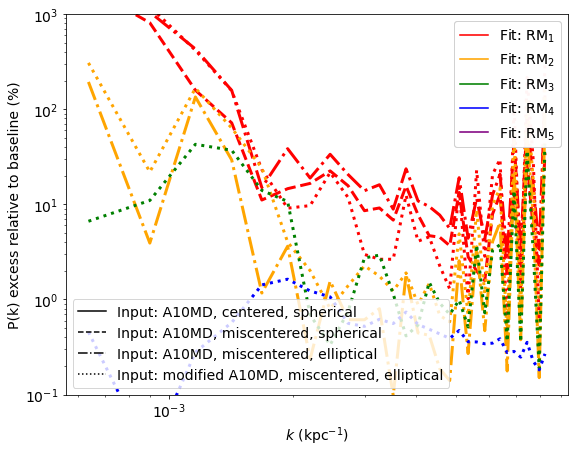

In [10]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(9, 7))
lss = ['solid', 'dashed', 'dashdot','dotted']
for j in range(len(inpars)):
    plt.plot(kref, 100*np.mean(pk1mc[j,:,:], axis=0) / pkref[j], color='red',    ls=lss[j], lw=3)
    plt.plot(kref, 100*np.mean(pk2mc[j,:,:], axis=0) / pkref[j], color='orange', ls=lss[j], lw=3)
    plt.plot(kref, 100*np.mean(pk3mc[j,:,:], axis=0) / pkref[j], color='green',  ls=lss[j], lw=3)
    plt.plot(kref, 100*np.mean(pk4mc[j,:,:], axis=0) / pkref[j], color='blue',   ls=lss[j], lw=3)
    plt.plot(kref, 100*np.mean(pk5mc[j,:,:], axis=0) / pkref[j], color='purple', ls=lss[j], lw=3)
    
plt.yscale('linear')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (kpc$^{-1}$)')
plt.ylabel(r'P(k) excess relative to baseline (%)')
plt.ylim(0.1,1000)

ax = plt.gca()
line0, = ax.plot([0],[0], ls=lss[0], color='k', label='Input: A10MD, centered, spherical')
line1, = ax.plot([0],[0], ls=lss[1], color='k', label='Input: A10MD, miscentered, spherical')
line2, = ax.plot([0],[0], ls=lss[2], color='k', label='Input: A10MD, miscentered, elliptical')
line3, = ax.plot([0],[0], ls=lss[3], color='k', label='Input: modified A10MD, miscentered, elliptical')

linea, = ax.plot([0],[0], color='red',    label='Fit: RM$_1$')
lineb, = ax.plot([0],[0], color='orange', label='Fit: RM$_2$')
linec, = ax.plot([0],[0], color='green',  label='Fit: RM$_3$')
lined, = ax.plot([0],[0], color='blue',   label='Fit: RM$_4$')
linee, = ax.plot([0],[0], color='purple', label='Fit: RM$_5$')

legend1 = ax.legend(handles=[line0,line1,line2,line3],       loc='lower left')
legend2 = ax.legend(handles=[linea,lineb,linec,lined,linee], loc='upper right')
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.savefig(outdir+'Bias_induced_radial_fit2.pdf')